In [736]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner
import dynesty
from tqdm import tqdm

In [737]:
def model_matrix_shaw(m, n):
    
    """
    Function to generate a model matrix of shaw problem
    
    Parameters
    ----------
    m: number of rows
    n: number of columns
    
    Returns
    -------
    s, theta, model matrix
    
    """
        
    del_theta = np.pi/n
    
    G = np.zeros((m, n))
    s = np.zeros(m)
    theta = np.zeros(n)
    
    for i in range(m):
        
        s[i] = (i - 0.5)*np.pi / m - np.pi/2  

        for j in range(n):
            
            theta[j] = (j - 0.5)*np.pi / n - np.pi/2
            
            if((np.pi*(np.sin(s[i]) + np.sin(theta[j]))) == 0):
                
                G[i,j] = (np.cos(s[i]) + np.cos(theta[j]))**2 * del_theta
                
            else:
                
                G[i,j] = (np.cos(s[i]) + np.cos(theta[j]))**2 * ((np.sin(np.pi*(np.sin(s[i]) + 
                                                np.sin(theta[j]))))/(np.pi*(np.sin(s[i]) + 
                                                np.sin(theta[j]))))**2 * del_theta
    return s, theta, G

def lstsqrSol(mprior, Cm, Cd, G, d_noisy, m, n):
    
    """
    Function to calculate a the least square solution of shaw problem
    
    Parameters
    ----------
    mean: number of rows
    G: number of columns
    d_noisy: noisy data
    Cm: model covariance matrix
    Cd: data covariance matrix
    m: no. of data samples
    
    Returns
    -------
    s, theta, model matrix
    
    """

    coeff = np.row_stack((np.sqrt(np.linalg.inv(Cd))@G, np.sqrt(np.linalg.inv(Cm))))
    val = np.row_stack((np.sqrt(np.linalg.inv(Cd))@d_noisy, np.sqrt(np.linalg.inv(Cm))@mprior.reshape(m, 1)))
    
    return np.linalg.lstsq(coeff, val, rcond=None)[0].flatten()

**Least square solution**

min$\left \|\begin{bmatrix}
\boldsymbol{C}^{-1/2}_D \, \boldsymbol{G}\\ 
\boldsymbol{C}^{-1/2}_M
\end{bmatrix}\, \boldsymbol{m} \, - \, \begin{bmatrix}
\boldsymbol{C}^{-1/2}_D \, \boldsymbol{d}\\ 
\boldsymbol{C}^{-1/2}_M \, \boldsymbol{m}_{\text{prior}}
\end{bmatrix}\right \|^2_2$

Solving the above equation give us MAP solution $\boldsymbol{m}_{\text{MAP}}$ with covariance of the posterior distribution given by

$\boldsymbol{C}_{M'} = \left ( \boldsymbol{G}^T\, \boldsymbol{C}^{-1}_D\, \boldsymbol{G} + \boldsymbol{C}^{-1}_{M} \right)^{-1}$



In [738]:
#-- generating model matrix ---
m, n = 20, 20
s, theta, G_model_shaw = model_matrix_shaw(m, n)

#-- input to the system ---
model = np.zeros(n).reshape(n,1)
model[9,0] = 1

#-- data generation ---
np.random.seed(0)
d_true = G_model_shaw@model  # true data
d_noisy = d_true + (sigma_data * np.random.randn(n)).reshape(n,1) # noisy data ~ d_true + 
                                                                           # N(0, sigma) 

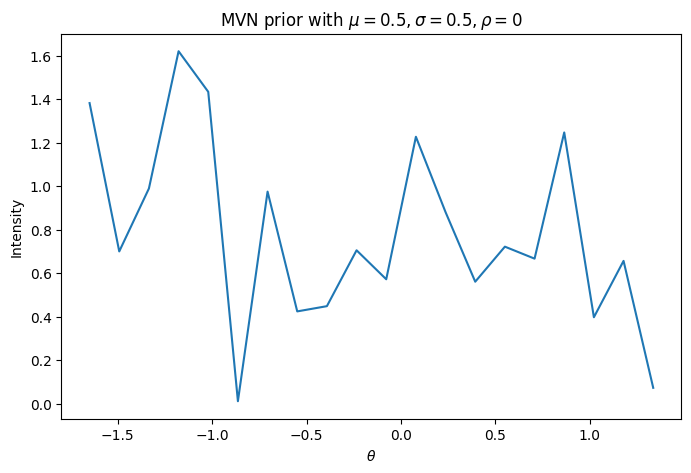

In [741]:
#-- model and data distribution parameters ----
mean_model = 0.5  # mean of the prior distribution
sigma_model = 0.5 # standard deviation of the prior distribution
sigma_data = 1e-6 # standard deviation of the conditional data distribution

mprior = mean_model*np.ones(m)  # mean array 

Cm = np.zeros((m, n))  # model covariance matrix
Cd = np.zeros((m, n))  # data covariance matrix

for i in range(m):

    for j in range(n):

        if(i==j):

            Cm[i, j] = sigma_model**2
            Cd[i, j] = sigma_data**2

plt.figure(figsize=(8,5))

np.random.seed(0)
plt.plot(theta, np.random.multivariate_normal(mprior, Cm, size=1).flatten())
plt.xlabel(r'$\theta$')
plt.ylabel('Intensity')
plt.title(r'MVN prior with $\mu = 0.5, \sigma = 0.5, \rho = 0$')
plt.show()

m_MAP = lstsqrSol(mprior, Cm, Cd, G_model_shaw, d_noisy, m, n)  # MAP solution
C_MAP = np.linalg.inv((G_model_shaw.T@np.linalg.inv(Cd))@G_model_shaw + np.linalg.inv(Cm)) # Covariance matrix corresponding 
                                                                                           # to MAP solution
#-- 95% Probability interval ---
m_upper = m_MAP + 1.96 * np.sqrt(np.diag(C_MAP))  
m_lower = m_MAP - 1.96 * np.sqrt(np.diag(C_MAP))


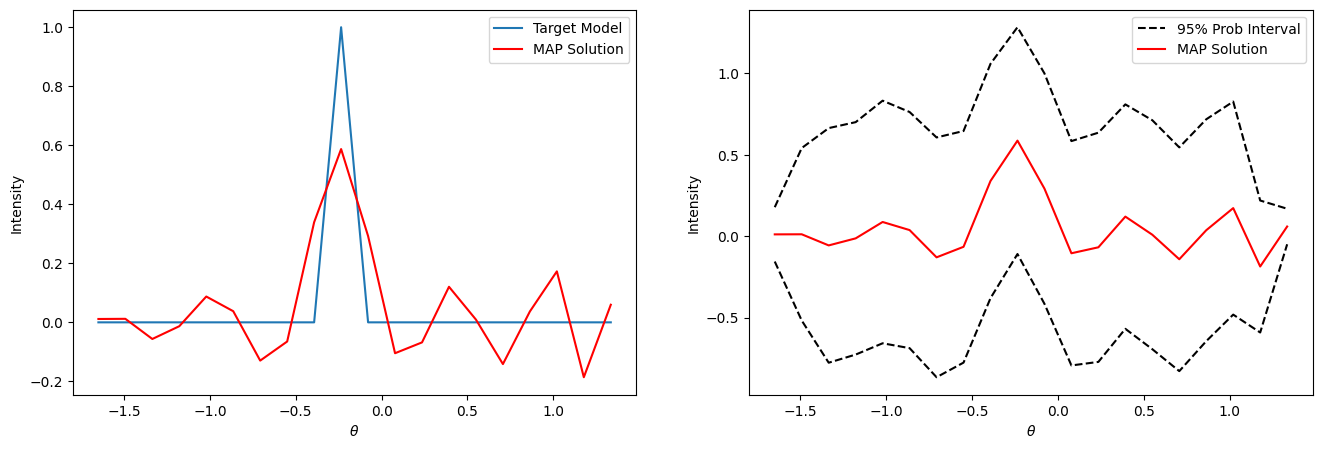

In [742]:
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(theta, model, label='Target Model')
plt.plot(theta, m_MAP, c='r', label='MAP Solution')
plt.xlabel(r'$\theta$')
plt.ylabel('Intensity')
plt.legend()

plt.subplot(122)
plt.plot(theta, m_lower, ls='--', c='k', label='95% Prob Interval')
plt.plot(theta, m_MAP, c='r', label='MAP Solution')
plt.plot(theta, m_upper, ls='--', c='k')
plt.xlabel(r'$\theta$')
plt.ylabel('Intensity')
plt.legend()

plt.show()